In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Read data

In [2]:
with open("heats.txt", "r") as f:
        columns = f.readline()
        data = f.readlines()

In [3]:
columns = columns.strip("\n").split("\t")
print("Data has {} columns: {}".format(len(columns), columns))

Data has 10 columns: ['"sbp"', '"tobacco"', '"ldl"', '"adiposity"', '"famhist"', '"typea"', '"obesity"', '"alcohol"', '"age"', '"chd"']


In [4]:
def clean(s):
    s = s.strip("\n").split("\t")
    return s
data = list(map(clean, data))
data = list(filter(lambda d:len(d)!=1, data))
print("There are totally {} samples.".format(len(data)))

There are totally 462 samples.


In [5]:
# Change famhist label to int
i = 0
for d in data:
    d[4] = int(d[4] == '"Present"')
    d = [float(e) for e in d]

In [6]:
data = np.array(data)
train_feature = data[:400, 0:9]
train_label = data[:400, 9]
test_feature = data[400:, 0:9]
test_label = data[400:, 9]
print("Data has shape: {}".format(data.shape))
print("Train feature has shape: {}".format(train_feature.shape))
print("Train label has shape: {}".format(train_label.shape))
print("Test feature has shape: {}".format(test_feature.shape))
print("Test label has shape: {}".format(test_label.shape))

Data has shape: (462, 10)
Train feature has shape: (400, 9)
Train label has shape: (400,)
Test feature has shape: (62, 9)
Test label has shape: (62,)


In [7]:
def next_batch(data, label, batch_size):
    data = np.hstack([train_feature, train_label.reshape(400,1)])
    np.random.shuffle(data)
    feature = data[:batch_size, 0:9]
    label = data[:batch_size, 9]
    return feature, label
next_feature, next_label = next_batch(train_feature, train_label, 256)
print(next_feature.shape)
print(next_label.shape)

(256, 9)
(256,)


 ## Define parameter      

In [8]:
batch_size = 128
learning_rate = 0.001
tf.set_random_seed(0)

## Define placeholder

In [9]:
X = tf.placeholder(tf.float32, shape=[None, 9], name="Input")
Y = tf.placeholder(tf.float32, shape=[None], name="Label")

## Define Variables

In [10]:
w1 = tf.Variable(tf.truncated_normal([9, 1], stddev=0.01), name="Weights1")
b1 = tf.Variable(tf.zeros([]), name="Bias1")

## Define sigmoid loss

In [11]:
with tf.name_scope("Loss"):
    logits = tf.sigmoid(tf.matmul(X, w1) + b1)
    loss = tf.reduce_mean(tf.square(logits - Y))

## Define train_op

In [12]:
with tf.name_scope("Optimizer"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)

## Define accuracy

In [13]:
with tf.name_scope("Accuracy"):
    predictions = tf.cast(logits > 0.5 , tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, Y), tf.float32))

## Define summary op

In [14]:
with tf.name_scope("Summaries"):
    loss_summary = tf.summary.scalar("loss", loss)
    tf.summary.histogram("histogram_loss", loss)
    tf.summary.scalar("accuracy", accuracy)
    summary_op = tf.summary.merge_all()

## Train

In [15]:
loss_history = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter("/tmp/graph/lg", sess.graph)
    for i in range(1000):
        next_feature, next_label = next_batch(train_feature, train_label, 256)
        _, np_loss, np_accuracy, summary = sess.run([train_op, loss, accuracy, summary_op],
                            feed_dict={X:next_feature, Y:next_label})
        if (i + 1) % 10 == 0:
            #print("Loss: {} Acc: {}".format(np_loss, np_accuracy))
            loss_history.append(np_loss)
            writer.add_summary(summary, global_step=i)
    
    # test model
    test_accuracy = sess.run(accuracy, feed_dict={X:test_feature, Y:test_label})
    print("Test accuracy: {}".format(test_accuracy))

Test accuracy: 0.7096773982048035


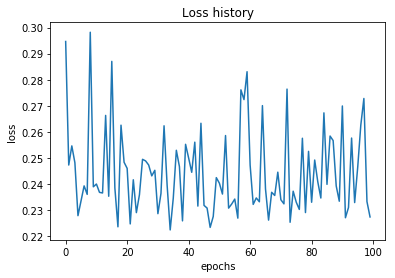

In [ ]:
plt.plot(loss_history)
plt.title('Loss history')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
!tensorboard --logdir="/tmp/graph/lg"

TensorBoard 0.1.6 at http://WangXs-MacBook-Air.local:6006 (Press CTRL+C to quit)
